In [1]:


import torch
torch.cuda.is_available()


True

In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sn

from sklearn.model_selection import train_test_split

from keras import models,layers
from sklearn import preprocessing 
# from keras.optimizers import Adam
import keras
from skimage.measure import block_reduce

from sklearn.metrics import classification_report,confusion_matrix,accuracy_score,f1_score
%matplotlib inline

2023-10-19 06:12:44.608288: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-19 06:12:45.785773: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [3]:
import os
os.environ["tf_gpu_allocator"]="cuda_malloc_async"

In [4]:
image_data= np.load("/home/yash/Downloads/images-001.npy")
image_data
image_labels=np.load("/home/yash/Downloads/labels.npy")
image_data.shape

(17736, 256, 256, 3)

(array([1081., 1853., 2645., 2027.,  334., 2043., 1829., 2628., 1423.,
        1873.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

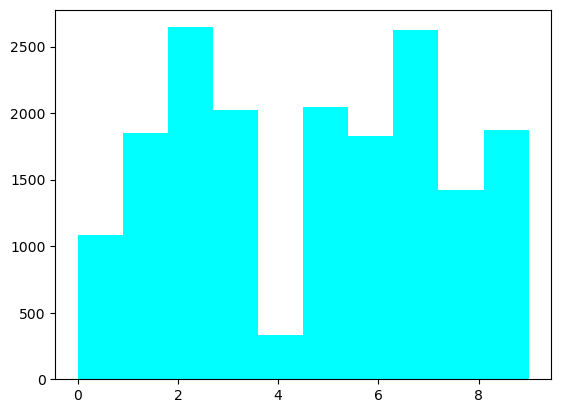

In [5]:

plt.hist(image_labels, color='cyan')

In [6]:
a=block_reduce(image_data,block_size=(1,8,8,1),func=np.mean)
a.shape

(17736, 32, 32, 3)

In [7]:
a=a/256

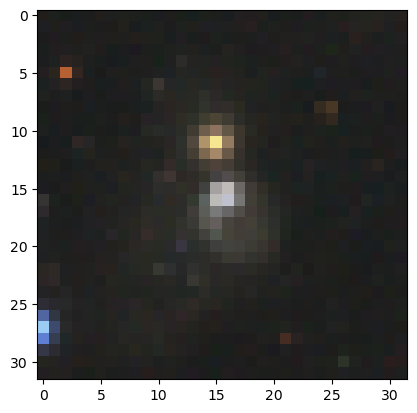

In [8]:
plt.imshow(a[1])

In [9]:
np.unique(image_labels)

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8)

image_data_reshape=image_data.reshape(-1,196608)
image_data[0]
image_data_reshape
df =pd.DataFrame(image_data_reshape)
df.describe
plt.imshow(df[1,])


In [10]:
image_data.shape

(17736, 256, 256, 3)

In [11]:
a.shape

(17736, 32, 32, 3)

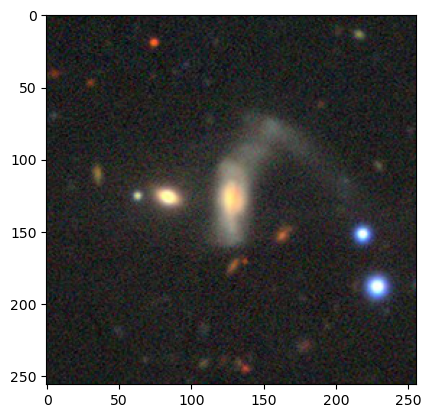

In [12]:
plt.imshow(image_data[0])

In [13]:
X_train,X_test,Y_train,Y_test=train_test_split(a,image_labels,test_size=0.1,random_state=1)
# X_train,X_test,Y_train,Y_test=train_test_split(image_data,image_labels,test_size=0.2)
tensor_Xtrain = tf.convert_to_tensor(X_train)
tensor_Xtest = tf.convert_to_tensor(X_test)
tensor_Ytrain = tf.convert_to_tensor(Y_train)
tensor_Ytest = tf.convert_to_tensor(Y_test)


2023-10-19 06:13:25.565392: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-19 06:13:25.646395: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-19 06:13:25.646621: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

In [14]:
Y_train.shape


(15962,)

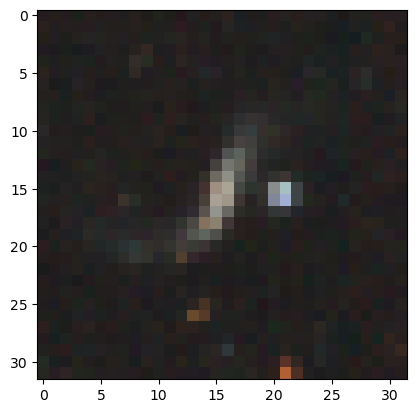

In [15]:
plt.imshow(X_train[0])

In [16]:
model_augmentaion = models.Sequential([
    layers.experimental.preprocessing.RandomContrast(0.3),
    layers.experimental.preprocessing.RandomZoom(0.1),
    layers.experimental.preprocessing.RandomRotation(0.50),
    layers.experimental.preprocessing.RandomFlip(mode="vertical")
])

In [17]:


model_cnn = models.Sequential([
        model_augmentaion,
        layers.Conv2D(filters=16,kernel_size=(8,8),activation='relu',input_shape=(32,32,3)),#,strides=(1,1),use_bias=True
        layers.Dropout(0.2),
        layers.MaxPool2D((2,2),padding='same'),
        layers.Conv2D(filters=32,kernel_size=(2,2),activation='relu'),#,use_bias=True
        layers.MaxPool2D((2,2),padding ='same'), 
        layers.Flatten(),
        layers.Dense(256,activation='relu',kernel_regularizer=tf.keras.regularizers.L1(l=0.01)),
        layers.Dropout(0.4),
        layers.Dense(170,activation='relu'),
        # layers.Dropout(0.2),
        layers.Dense(112,activation='relu'),
        # layers.Dropout(0.2),
        layers.Dense(75,activation='relu'),
        # layers.Dropout(0.2),
        layers.Dropout(0.2),
        layers.Dense(10,activation='softmax')
        ])

opt =tf.keras.optimizers.Adam(learning_rate=0.001)

model_cnn.compile(optimizer=opt,
    loss= 'sparse_categorical_crossentropy',
    metrics=['accuracy',]
#     tf.keras.metrics.sparse_categorical_accuracy
    )

In [18]:
model_cnn.fit(tensor_Xtrain,tensor_Ytrain,epochs=10,verbose=1,batch_size=256,validation_data=(tensor_Xtest,tensor_Ytest),)
accuracy_mod=model_cnn.evaluate(tensor_Xtest,tensor_Ytest)

Epoch 1/10


2023-10-19 06:13:26.350269: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 392282112 exceeds 10% of free system memory.
2023-10-19 06:13:27.884272: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2023-10-19 06:13:28.205372: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:432] Loaded cuDNN version 8600
2023-10-19 06:13:28.407690: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-10-19 06:13:28.408213: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-10-19 06:13:28.408238: W tensorflow/compiler/xla/stream_executor/gpu/asm_compiler.cc:109] Couldn't get ptxas version : FAILED_PRECONDITION: Couldn't get ptxas/nvlink version string: INTER

InternalError: Graph execution error:

Detected at node 'Adam/StatefulPartitionedCall_12' defined at (most recent call last):
    File "<frozen runpy>", line 198, in _run_module_as_main
    File "<frozen runpy>", line 88, in _run_code
    File "/home/yash/anaconda3/lib/python3.11/site-packages/ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "/home/yash/anaconda3/lib/python3.11/site-packages/traitlets/config/application.py", line 992, in launch_instance
      app.start()
    File "/home/yash/anaconda3/lib/python3.11/site-packages/ipykernel/kernelapp.py", line 711, in start
      self.io_loop.start()
    File "/home/yash/anaconda3/lib/python3.11/site-packages/tornado/platform/asyncio.py", line 195, in start
      self.asyncio_loop.run_forever()
    File "/home/yash/anaconda3/lib/python3.11/asyncio/base_events.py", line 607, in run_forever
      self._run_once()
    File "/home/yash/anaconda3/lib/python3.11/asyncio/base_events.py", line 1922, in _run_once
      handle._run()
    File "/home/yash/anaconda3/lib/python3.11/asyncio/events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "/home/yash/anaconda3/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "/home/yash/anaconda3/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "/home/yash/anaconda3/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 406, in dispatch_shell
      await result
    File "/home/yash/anaconda3/lib/python3.11/site-packages/ipykernel/kernelbase.py", line 729, in execute_request
      reply_content = await reply_content
    File "/home/yash/anaconda3/lib/python3.11/site-packages/ipykernel/ipkernel.py", line 411, in do_execute
      res = shell.run_cell(
    File "/home/yash/anaconda3/lib/python3.11/site-packages/ipykernel/zmqshell.py", line 531, in run_cell
      return super().run_cell(*args, **kwargs)
    File "/home/yash/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3006, in run_cell
      result = self._run_cell(
    File "/home/yash/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3061, in _run_cell
      result = runner(coro)
    File "/home/yash/anaconda3/lib/python3.11/site-packages/IPython/core/async_helpers.py", line 129, in _pseudo_sync_runner
      coro.send(None)
    File "/home/yash/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3266, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "/home/yash/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3445, in run_ast_nodes
      if await self.run_code(code, result, async_=asy):
    File "/home/yash/anaconda3/lib/python3.11/site-packages/IPython/core/interactiveshell.py", line 3505, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "/tmp/ipykernel_19955/2596632062.py", line 1, in <module>
      model_cnn.fit(tensor_Xtrain,tensor_Ytrain,epochs=10,verbose=1,batch_size=256,validation_data=(tensor_Xtest,tensor_Ytest),)
    File "/home/yash/anaconda3/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "/home/yash/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1742, in fit
      tmp_logs = self.train_function(iterator)
    File "/home/yash/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1338, in train_function
      return step_function(self, iterator)
    File "/home/yash/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1322, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/home/yash/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1303, in run_step
      outputs = model.train_step(data)
    File "/home/yash/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py", line 1084, in train_step
      self.optimizer.minimize(loss, self.trainable_variables, tape=tape)
    File "/home/yash/anaconda3/lib/python3.11/site-packages/keras/src/optimizers/optimizer.py", line 544, in minimize
      self.apply_gradients(grads_and_vars)
    File "/home/yash/anaconda3/lib/python3.11/site-packages/keras/src/optimizers/optimizer.py", line 1230, in apply_gradients
      return super().apply_gradients(grads_and_vars, name=name)
    File "/home/yash/anaconda3/lib/python3.11/site-packages/keras/src/optimizers/optimizer.py", line 652, in apply_gradients
      iteration = self._internal_apply_gradients(grads_and_vars)
    File "/home/yash/anaconda3/lib/python3.11/site-packages/keras/src/optimizers/optimizer.py", line 1260, in _internal_apply_gradients
      return tf.__internal__.distribute.interim.maybe_merge_call(
    File "/home/yash/anaconda3/lib/python3.11/site-packages/keras/src/optimizers/optimizer.py", line 1352, in _distributed_apply_gradients_fn
      distribution.extended.update(
    File "/home/yash/anaconda3/lib/python3.11/site-packages/keras/src/optimizers/optimizer.py", line 1347, in apply_grad_to_update_var
      return self._update_step_xla(grad, var, id(self._var_key(var)))
Node: 'Adam/StatefulPartitionedCall_12'
libdevice not found at ./libdevice.10.bc
	 [[{{node Adam/StatefulPartitionedCall_12}}]] [Op:__inference_train_function_3222]

In [ ]:
model_cnn.summary()

In [ ]:
accuracy_mod

[1.8099560737609863, 0.5332581996917725]

In [ ]:
a.shape

(17736, 32, 32, 3)

In [ ]:
a_resahpe=a.reshape(17736,3072)
a_resahpe.shape

(17736, 3072)

In [ ]:
from sklearn.model_selection import StratifiedKFold
fold = StratifiedKFold(n_splits=5)
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=3)

In [ ]:
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy="minority")
X_smote,Y_smote =smote.fit_resample(a_resahpe,image_labels)

Exception ignored on calling ctypes callback function: <function _ThreadpoolInfo._find_modules_with_dl_iterate_phdr.<locals>.match_module_callback at 0x7f5c55fa6b60>
Traceback (most recent call last):
  File "/home/yash/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 400, in match_module_callback
    self._make_module_from_path(filepath)
  File "/home/yash/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 515, in _make_module_from_path
    module = module_class(filepath, prefix, user_api, internal_api)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/yash/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 606, in __init__
    self.version = self.get_version()
                   ^^^^^^^^^^^^^^^^^^
  File "/home/yash/anaconda3/lib/python3.11/site-packages/threadpoolctl.py", line 646, in get_version
    config = get_config().split()
             ^^^^^^^^^^^^^^^^^^
AttributeError: 'NoneType' object has no attribute 's

In [ ]:
X_smote=X_smote.reshape(20047,32,32,3)

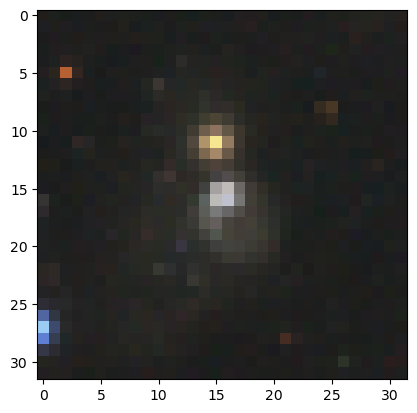

In [ ]:
plt.imshow(X_smote[1])

In [ ]:
X_smote.shape

(20047, 32, 32, 3)

(array([1081., 1853., 2645., 2027., 2645., 2043., 1829., 2628., 1423.,
        1873.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

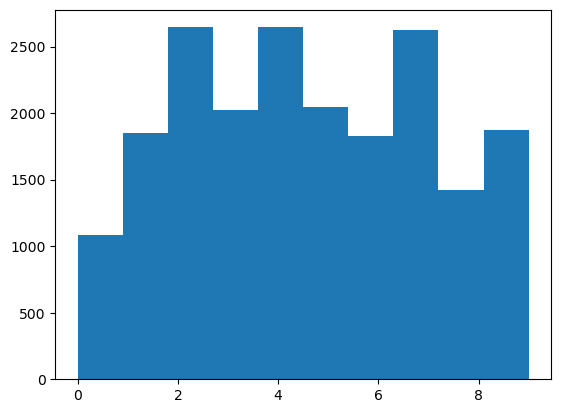

In [ ]:

plt.hist(Y_smote)

In [ ]:
image_data_smote = np.concatenate((a,X_smote ))
image_labels_smote = np.concatenate((image_labels,Y_smote ))

(array([2162., 3706., 5290., 4054., 2979., 4086., 3658., 5256., 2846.,
        3746.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <BarContainer object of 10 artists>)

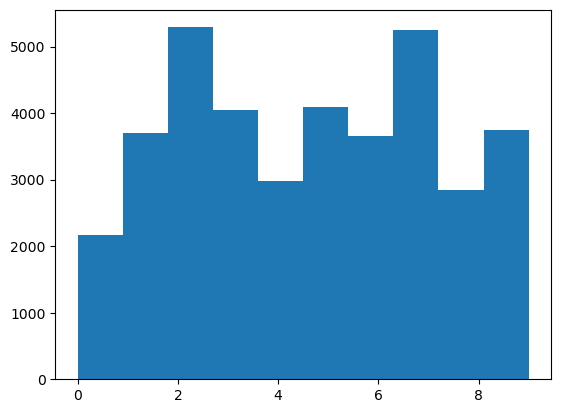

In [ ]:
plt.hist(image_labels_smote)

In [ ]:
X_train,X_test,Y_train,Y_test=train_test_split(image_data_smote,image_labels_smote,test_size=0.1,random_state=5)
# X_train,X_test,Y_train,Y_test=train_test_split(image_data,image_labels,test_size=0.2)
tensor_Xtrain = tf.convert_to_tensor(X_train)
tensor_Xtest = tf.convert_to_tensor(X_test)
tensor_Ytrain = tf.convert_to_tensor(Y_train)
tensor_Ytest = tf.convert_to_tensor(Y_test)


2023-10-19 06:10:52.930063: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 835682304 exceeds 10% of free system memory.


model_cnn.fit(tensor_Xtrain,tensor_Ytrain,epochs=50,verbose=1,batch_size=4000,validation_data=(tensor_Xtest,tensor_Ytest))
accuracy_mod=model_cnn.evaluate(tensor_Xtest,tensor_Ytest)

In [ ]:
def NeuralNetwork(Train_X,Test_X,Train_Y,Test_Y,Epochs,batch_size_value):

    model_cnn = models.Sequential([
        model_augmentaion,
        layers.Conv2D(filters=16,kernel_size=(8,8),activation='relu',input_shape=(32,32,3)),#,strides=(1,1),use_bias=True
        layers.Dropout(0.2),
        layers.MaxPool2D((2,2),padding='same'),
        layers.Conv2D(filters=32,kernel_size=(2,2),activation='relu'),#,use_bias=True
        layers.MaxPool2D((2,2),padding ='same'), 
        layers.Flatten(),
        layers.Dense(256,activation='relu',kernel_regularizer=tf.keras.regularizers.L1(l=0.01)),
        layers.Dropout(0.4),
        layers.Dense(170,activation='relu'),
        # layers.Dropout(0.2),
        layers.Dense(112,activation='relu'),
        # layers.Dropout(0.2),
        layers.Dense(75,activation='relu'),
        # layers.Dropout(0.2),
        layers.Dropout(0.2),
        layers.Dense(10,activation='softmax')
        ])

    opt =tf.keras.optimizers.Adam(learning_rate=0.001)

    model_cnn.compile(optimizer=opt,
        loss= 'sparse_categorical_crossentropy',
        metrics=['accuracy',]
    #     tf.keras.metrics.sparse_categorical_accuracy
        )
    model_cnn.fit(Train_X,Train_Y,epochs=Epochs,verbose=1,batch_size=batch_size_value,validation_data=(Test_X,Test_Y))
    accuracy_mod=model_cnn.evaluate(tensor_Xtest,tensor_Ytest)

    YPred=model_cnn.predict(tensor_Xtest)
    accur = accuracy_score(tensor_Ytest,YPred)

    return(accur)

In [ ]:
def AccuracyModel(Test_X,Test_Y):
    Y_pred=model_cnn.predict(Test_X)
    print(classification_report(Test_Y,Y_pred))
    cm =tf.math.confusion_matrix(labels=Test_Y,predictions=Y_pred)

    plt.figure(figsize=(10,7))
    sn.heatmap(cm,annot=True,fmt='d')
    plt.xlabel('Predicted')
    plt.ylabel('Truth')

In [ ]:
def TrainSplit(RandomState):
    X_train,X_test,Y_train,Y_test=train_test_split(image_data_smote,image_labels_smote,test_size=0.1,random_state=RandomState)
    # X_train,X_test,Y_train,Y_test=train_test_split(image_data,image_labels,test_size=0.2)
    tensor_Xtrain = tf.convert_to_tensor(X_train)
    tensor_Xtest = tf.convert_to_tensor(X_test)
    tensor_Ytrain = tf.convert_to_tensor(Y_train)
    tensor_Ytest = tf.convert_to_tensor(Y_test)
    

1-0.50
2

In [ ]:
i=0
while (i!=10):
    TrainSplit(i)
    print(i)
    i+=1
    acc=NeuralNetwork(tensor_Xtrain,tensor_Xtest,tensor_Ytrain,tensor_Ytest,50,4000)

0
Epoch 1/50
9/9 [==============================] - 13s 1s/step - loss: 87.9630 - accuracy: 0.1411 - val_loss: 74.1070 - val_accuracy: 0.1958
Epoch 2/50
9/9 [==============================] - 11s 1s/step - loss: 65.2019 - accuracy: 0.1668 - val_loss: 53.5282 - val_accuracy: 0.2096
Epoch 3/50
9/9 [==============================] - 11s 1s/step - loss: 46.1522 - accuracy: 0.1940 - val_loss: 36.6073 - val_accuracy: 0.2114
Epoch 4/50
9/9 [==============================] - 11s 1s/step - loss: 30.7865 - accuracy: 0.2006 - val_loss: 23.4253 - val_accuracy: 0.1998
Epoch 5/50
9/9 [==============================] - 11s 1s/step - loss: 19.0563 - accuracy: 0.2077 - val_loss: 13.6875 - val_accuracy: 0.2202
Epoch 6/50
9/9 [==============================] - 11s 1s/step - loss: 10.7774 - accuracy: 0.2230 - val_loss: 7.4065 - val_accuracy: 0.2260
Epoch 7/50
9/9 [==============================] - 11s 1s/step - loss: 5.9764 - accuracy: 0.2225 - val_loss: 4.6597 - val_accuracy: 0.2302
Epoch 8/50
9/9 [=====

In [ ]:
TrainSplit(1)

accuracy=NeuralNetwork(tensor_Xtrain,tensor_Xtest,tensor_Ytrain,tensor_Ytest,10,512)

2023-10-19 06:12:28.661615: W tensorflow/tsl/framework/bfc_allocator.cc:485] Allocator (GPU_0_bfc) ran out of memory trying to allocate 796.97MiB (rounded to 835682304)requested by op _EagerConst
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2023-10-19 06:12:28.662009: I tensorflow/tsl/framework/bfc_allocator.cc:1039] BFCAllocator dump for GPU_0_bfc
2023-10-19 06:12:28.662036: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (256): 	Total Chunks: 95, Chunks in use: 95. 23.8KiB allocated for chunks. 23.8KiB in use in bin. 1.9KiB client-requested in use in bin.
2023-10-19 06:12:28.662049: I tensorflow/tsl/framework/bfc_allocator.cc:1046] Bin (512): 	Total Chunks: 19, Chunks in use: 18. 11.5KiB allocated for chunks. 10.8KiB in use in bin. 8.4KiB client-requested in use in bin.
2023-10-19 06:12:28.662061: I tensorflow/tsl/frame

InternalError: Failed copying input tensor from /job:localhost/replica:0/task:0/device:CPU:0 to /job:localhost/replica:0/task:0/device:GPU:0 in order to run _EagerConst: Dst tensor is not initialized.

:12:28.662427: I tensorflow/tsl/framework/bfc_allocator.cc:1095] InUse at 7f59fbfb5e00 of size 256 next 23
2023-10-19 06:12:28.662433: I tensorflow/tsl/framework/bfc_allocator.cc:1095] InUse at 7f59fbfb5f00 of size 1024 next 31
2023-10-19 06:12:28.662439: I tensorflow/tsl/framework/bfc_allocator.cc:1095] InUse at 7f59fbfb6300 of size 256 next 28
2023-10-19 06:12:28.662444: I tensorflow/tsl/framework/bfc_allocator.cc:1095] InUse at 7f59fbfb6400 of size 256 next 30
2023-10-19 06:12:28.662449: I tensorflow/tsl/framework/bfc_allocator.cc:1095] InUse at 7f59fbfb6500 of size 768 next 36
2023-10-19 06:12:28.662455: I tensorflow/tsl/framework/bfc_allocator.cc:1095] InUse at 7f59fbfb6800 of size 256 next 34
2023-10-19 06:12:28.662460: I tensorflow/tsl/framework/bfc_allocator.cc:1095] InUse at 7f59fbfb6900 of size 256 next 35
2023-10-19 06:12:28.662466: I tensorflow/tsl/framework/bfc_allocator.cc:1095] InUse at 7f59fbfb6a00 of size 512 next 41
2023-10-19 06:12:28.662471: I tensorflow/tsl/framewo